
# Procesamiento Digital de Señales en Sistemas Embebidos

---

# TP4: Filtrado Digital *(parte 1)*

## Introducción

El algoritmo Pan-Tompkins se usa comúnmente para detectar complejos QRS en señales electrocardiográficas (ECG). El complejo QRS representa la despolarización ventricular y el pico principal visible en una señal de ECG (ver figura). Esta característica lo hace especialmente adecuado para medir la frecuencia cardíaca, la primera forma de evaluar el estado de salud del corazón.

El algoritmo de Pan-Tompkins aplica una serie de filtros para resaltar el contenido de frecuencia del QRS y eliminar el ruido de fondo. Luego deriva y cuadra la señal para amplificar la contribución QRS, lo que hace que la identificación del complejo QRS sea más sencilla. Finalmente integra la señal y aplica umbrales para detectar los picos.

![pan-tompkins](pan-tompkins.png)

El filtro aplicado en el primer paso para aumentar la relación señal-ruido consiste en un pasa-banda. Se sugiere un ancho de banda de filtro de 5 a 15 Hz para maximizar la contribución de QRS y reducir el ruido muscular, la desviación de la línea de base, la interferencia de la línea eléctrica y el contenido de frecuencia de onda P/onda T. Este filtro estaba originalmente implementado mediante un pasa bajos y un pasa altos, y presentaba una atenuación de aproximadamente 20dB para frecuencias de 1Hz y 50Hz.

## Consignas

A partir de una señal de ECG descargada del Repositorio de Physionet, replicar la acción de filtrado correspondiente a la primera etapa del algoritmo de Pan-Tompkins.
Para ello:
1. Proponer dos diseños de filtros con los requerimientos mencionados, utilizando un filtro de tipo FIR y uno de tipo IIR.
2. Probar dichos filtros sobre un registro de ECG en Python.
3. Implementar ambos filtros en el ESP32, y probarlos también utilizando la misma señal de ECG.

## Diseño de filtros digitales

Se presenteran varias herramientas distintas para el diseño de filtros digitales, que luego se podrán utilizar tanto para pruebas en python, como también para la implementación en el ESP32.

In [1]:
# Incluir librerías
from scipy import signal, fft
import numpy as np
import matplotlib.pyplot as plt

---
### Micromodeler DSP

https://www.micromodeler.com/

![micromodeler](micromodeler.jpg)

#### Filtro IIR 
Se utilizó un filtro Butterworth pasa-banda de orden 8, con frecuencias de corte en 5 y 15Hz. 
Se exportan los coeficientes con una aritmética de punto flotante, organizados en secciones de orden dos (SOS).
Micromodeler ordena los coeficientes de las SOS como:

`[b0, b1, b2, a1, a2]`

Para utilizarlos con el módulo *scipy* en *python* debemos expresarlos como:

`[b0, b1, b2, a0, -a1, -a2]`

siendo a0 = 1 (los coeficientes están normalizados).

In [2]:
sos_iir_1 = [[0.023879506018041567, 0.04775901203608313, 0.023879506018041567, 1, -1.782312015127054, 0.8169043136006663], 
             [0.5, -1, 0.5, 1, -1.8727120022494252, 0.8856363861548432],
             [0.0078125, 0.015625, 0.0078125, 1, -1.8452018524584375, 0.9065304015992756],
             [0.5, -1, 0.5, 1, -1.9576917383162364, 0.96562417674302]] 

#### Filtro FIR 

Se utilizó un filtro mediante el método de ventaneo, utilizando una ventana rectangular (tras varias pruebas, fue con la que mejor aproximación se obtuvo). 
El orden del filtro es 21, el máximo permitido por la herramienta.
Se exportan los coeficientes con una aritmética de punto flotante.

In [3]:
num_fir_1 = [-0.071488410, -0.072959286, -0.071854345, -0.062158068, 
             -0.039125342, -0.0022398888, 0.043459476, 0.088364179, 
             0.12130080, 0.13340178, 0.12130080, 0.088364179,
             0.043459476, -0.0022398888, -0.039125342, -0.062158068, 
             -0.071854345, -0.072959286, -0.071488410]

#### Respuesta en frecuencia

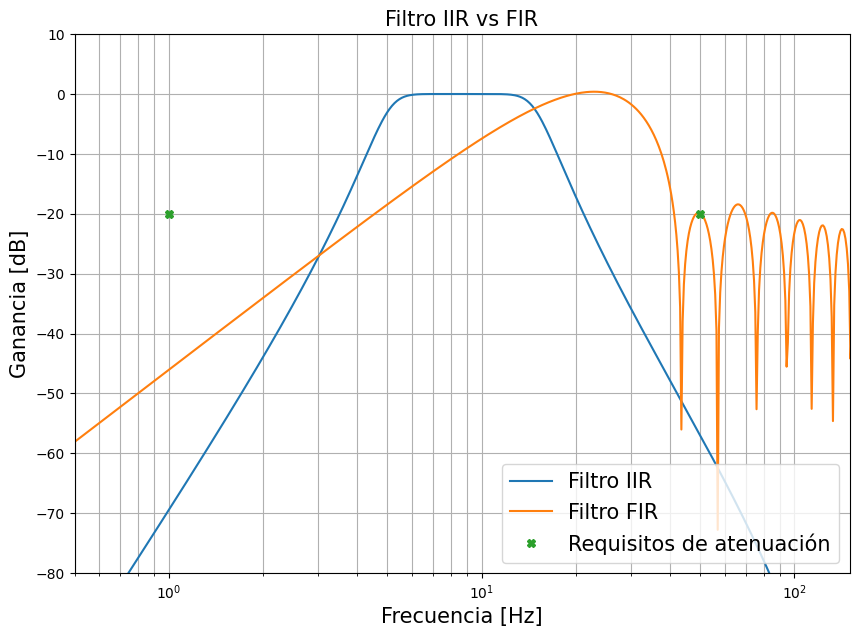

In [4]:
fs = 360

# se genera un vector de frecuencias
f = np.logspace(-1, 3, int(1e3))
# se analiza la respuesta en frecuencia de ambos filtros
f, h_iir_1 = signal.sosfreqz(sos_iir_1, worN=f, fs=fs)
f, h_fir_1 = signal.freqz(num_fir_1, 1, worN=f, fs=fs)

# se grafican ambas respuestas en frecuencia superpuestas
fig1, ax1 = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
ax1.plot(f, 20*np.log10(abs(h_iir_1)), label='Filtro IIR')
ax1.plot(f, 20*np.log10(abs(h_fir_1)), label='Filtro FIR')
ax1.plot([1, 50], [-20, -20], 'X', label='Requisitos de atenuación')
ax1.set_ylabel('Ganancia [dB]', fontsize=15)
ax1.set_xlabel('Frecuencia [Hz]', fontsize=15)
ax1.grid(which='both')
ax1.legend(loc="lower right", fontsize=15)
ax1.set_title('Filtro IIR vs FIR', fontsize=15)
ax1.set_xscale('log')
ax1.set_xlim([0.5, 150])
ax1.set_ylim([-80, 10])

plt.show()

---
### pyFDA

[Documentación](https://pyfda.readthedocs.io/en/latest/)

[Descarga (v0.70)](https://github.com/chipmuenk/pyfda/releases/download/v0.7.0/pyfdax_win.exe)

![pyfda](pyfda.png)

#### Filtro IIR

In [5]:
# se carga el filtro diseñado mediante pyFDA
filtro_iir = np.load('filtro_iir.npz', allow_pickle=True)

# podemos recuperar los parámetros del filtro
print("Tipo de filtro {}".format(  filtro_iir['rt'])) 
print("Aproximación utilizada:" + filtro_iir['creator'][1])  
print("Frecuencia de muestreo: {:.1f} Hz".format(filtro_iir['f_S']))  
print("Orden del filtro: {:}".format(2*filtro_iir['N']))            # Al ser pasa banda el orden se duplica
print("Frecuencia banda de rechazo inferior: {:.1f} Hz".format(filtro_iir['F_SB']*filtro_iir['f_S']))
print("Frecuencia inferior banda de paso : {:.1f} Hz".format(filtro_iir['F_PB']*filtro_iir['f_S']))
print("Frecuencia superior banda de paso : {:.1f} Hz".format(filtro_iir['F_PB2']*filtro_iir['f_S']))
print("Frecuencia banda de rechazo superior: {:.1f} Hz".format(filtro_iir['F_SB2']*filtro_iir['f_S']))

# Se extraen los coeficientes de numerador y denominador
num_iir_2, den_iir_2 = filtro_iir['ba']  
print("Coeficientes numerador:")
print(num_iir_2)
print("Coeficientes denominador:")
print(den_iir_2)

# Se convierte a secciones de orden dos (SOS)
sos_iir_2 = signal.tf2sos(num_iir_2, den_iir_2)
print("Secciones de orden 2:")
print(sos_iir_2)

Tipo de filtro BP
Aproximación utilizada:pyfda.filter_widgets.cheby1
Frecuencia de muestreo: 360.0 Hz
Orden del filtro: 4
Frecuencia banda de rechazo inferior: 1.0 Hz
Frecuencia inferior banda de paso : 5.0 Hz
Frecuencia superior banda de paso : 15.0 Hz
Frecuencia banda de rechazo superior: 50.0 Hz
Coeficientes numerador:
[ 0.00680972  0.         -0.01361943  0.          0.00680972]
Coeficientes denominador:
[ 1.         -3.752144    5.33482796 -3.40830186  0.82609108]
Secciones de orden 2:
[[ 0.00680972  0.01361943  0.00680972  1.         -1.80936695  0.86890704]
 [ 1.         -2.          1.          1.         -1.94277705  0.95072435]]


#### Filtro FIR

In [6]:
# se carga el filtro diseñado mediante pyFDA
filtro_fir = np.load('filtro_fir.npz', allow_pickle=True)

# podemos recuperar los parámetros del filtro
print("Tipo de filtro {}".format(  filtro_fir['rt'])) 
print("Aproximación utilizada:" + filtro_fir['creator'][1])  
print("Frecuencia de muestreo: {:.1f} Hz".format(filtro_fir['f_S']))  
print("Orden del filtro: {:}".format(2*filtro_fir['N']))            # Al ser pasa banda el orden se duplica
print("Frecuencia banda de rechazo inferior: {:.1f} Hz".format(filtro_fir['F_SB']*filtro_fir['f_S']))
print("Frecuencia inferior banda de paso : {:.1f} Hz".format(filtro_fir['F_PB']*filtro_fir['f_S']))
print("Frecuencia superior banda de paso : {:.1f} Hz".format(filtro_fir['F_PB2']*filtro_fir['f_S']))
print("Frecuencia banda de rechazo superior: {:.1f} Hz".format(filtro_fir['F_SB2']*filtro_fir['f_S']))

# Se extraen los coeficientes de numerador y denominador
num_fir_2, den_fir_2 = filtro_fir['ba'] 
print("Coeficientes numerador:")
print(num_fir_2)
print("Coeficientes denominador:")
print(den_fir_2)

Tipo de filtro BP
Aproximación utilizada:pyfda.filter_widgets.equiripple
Frecuencia de muestreo: 360.0 Hz
Orden del filtro: 328
Frecuencia banda de rechazo inferior: 3.0 Hz
Frecuencia inferior banda de paso : 5.0 Hz
Frecuencia superior banda de paso : 15.0 Hz
Frecuencia banda de rechazo superior: 18.0 Hz
Coeficientes numerador:
[-0.02950435  0.02824013  0.01621326  0.00838789  0.00362666  0.00111867
  0.00024981  0.00053086  0.00155244  0.00296906  0.00448867  0.00587536
  0.00695151  0.00759998  0.0077646   0.00744647  0.00669834  0.00561472
  0.00431901  0.00295101  0.00165143  0.00055011 -0.00024564 -0.00066227
 -0.00066493 -0.00025958  0.0005076   0.00155562  0.00277384  0.00403162
  0.00519196  0.00612178  0.00670225  0.00684029  0.00647693  0.00559306
  0.00421164  0.00239662  0.00025011 -0.00209436 -0.00448343 -0.00675553
 -0.00875128 -0.01032738 -0.01137112 -0.01180936 -0.01161552 -0.01081549
 -0.00948815 -0.00776166 -0.0058059  -0.00382196 -0.0020289  -0.00064552
  0.00012721 

#### Respuesta en Frecuencia

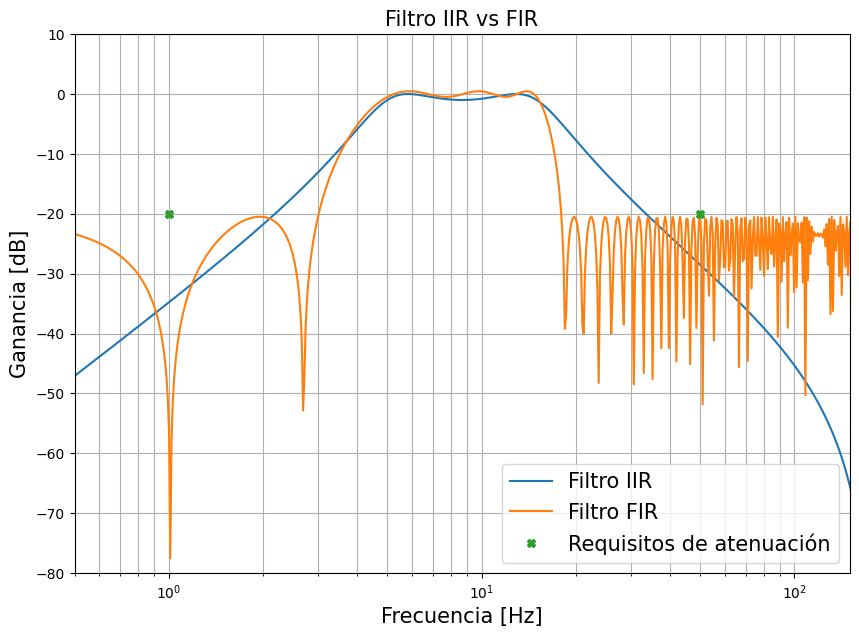

In [7]:
fs = 360

# se genera un vector de frecuencias
f = np.logspace(-1, 3, int(1e3))
# se analiza la respuesta en frecuencia de ambos filtros
f, h_iir_2 = signal.sosfreqz(sos_iir_2, worN=f, fs=fs)
f, h_fir_2 = signal.freqz(num_fir_2, 1, worN=f, fs=fs)

# se grafican ambas respuestas en frecuencia superpuestas
fig1, ax1 = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
ax1.plot(f, 20*np.log10(abs(h_iir_2)), label='Filtro IIR')
ax1.plot(f, 20*np.log10(abs(h_fir_2)), label='Filtro FIR')
ax1.plot([1, 50], [-20, -20], 'X', label='Requisitos de atenuación')
ax1.set_ylabel('Ganancia [dB]', fontsize=15)
ax1.set_xlabel('Frecuencia [Hz]', fontsize=15)
ax1.grid(which='both')
ax1.legend(loc="lower right", fontsize=15)
ax1.set_title('Filtro IIR vs FIR', fontsize=15)
ax1.set_xscale('log')
ax1.set_xlim([0.5, 150])
ax1.set_ylim([-80, 10])

plt.show()

---
### SciPy

[Documentación](https://docs.scipy.org/doc/scipy/reference/signal.html)

![scipy](scipy.png)

#### Filtro IIR

In [11]:
fs = 360

# Se analiza el orden necesario para cumplir los requisitos utilizando un filtro Butterworth
N, wn = signal.buttord([5, 15], [1, 50], 3, 20, analog=False, fs=fs)
# Se genera el filtro con el orden calculado
sos_iir_3 = signal.butter(N, wn, 'bandpass', analog=False, output='sos', fs=fs)

print("Secciones de orden 2:")
print(sos_iir_2)

Secciones de orden 2:
[[ 0.00680972  0.01361943  0.00680972  1.         -1.80936695  0.86890704]
 [ 1.         -2.          1.          1.         -1.94277705  0.95072435]]


#### Filtro FIR

In [12]:
# Proponemos un orden 
N = 101
num_fir_3 = signal.firwin(N, cutoff=[5, 15], window='hamming', pass_zero='bandpass', fs=fs)

print("Coeficientes del filtro:")
print(num_fir_3)

Coeficientes del filtro:
[ 7.58765761e-04  6.33701842e-04  4.96998535e-04  3.46160972e-04
  1.79938591e-04 -7.36107553e-19 -1.87682447e-04 -3.72024387e-04
 -5.36832404e-04 -6.61767270e-04 -7.24303547e-04 -7.02592850e-04
 -5.79007250e-04 -3.44021251e-04  5.53063512e-19  4.35589626e-04
  9.28030620e-04  1.42470456e-03  1.85626815e-03  2.13983809e-03
  2.18418016e-03  1.89669401e-03  1.19178124e-03 -8.65879415e-19
 -1.72273545e-03 -3.98674001e-03 -6.76177628e-03 -9.97269746e-03
 -1.34981714e-02 -1.71729381e-02 -2.07937938e-02 -2.41291952e-02
 -2.69320709e-02 -2.89551269e-02 -2.99676795e-02 -2.97728546e-02
 -2.82238857e-02 -2.52382304e-02 -2.08083174e-02 -1.50079299e-02
 -7.99350736e-03  0.00000000e+00  8.66869929e-03  1.76543174e-02
  2.65629433e-02  3.49868027e-02  4.25276624e-02  4.88203063e-02
  5.35544862e-02  5.64938323e-02  5.74904001e-02  5.64938323e-02
  5.35544862e-02  4.88203063e-02  4.25276624e-02  3.49868027e-02
  2.65629433e-02  1.76543174e-02  8.66869929e-03  0.00000000e+00


#### Respuesta en Frecuencia

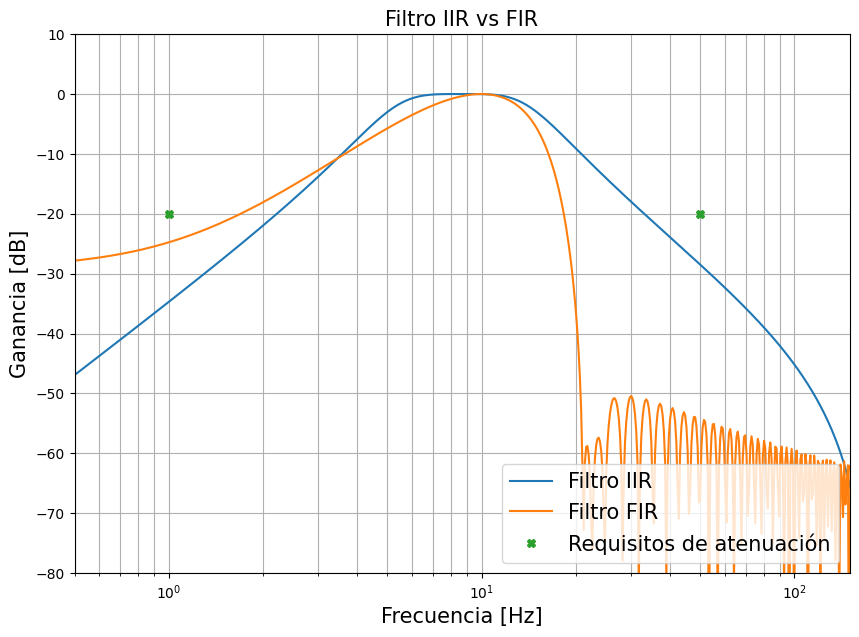

In [13]:
# se genera un vector de frecuencias
f = np.logspace(-1, 3, int(1e3))
# se analiza la respuesta en frecuencia de ambos filtros
f, h_iir_3 = signal.sosfreqz(sos_iir_3, worN=f, fs=fs)
f, h_fir_3 = signal.freqz(num_fir_3, 1, worN=f, fs=fs)

# se grafican ambas respuestas en frecuencia superpuestas
fig1, ax1 = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
ax1.plot(f, 20*np.log10(abs(h_iir_3)), label='Filtro IIR')
ax1.plot(f, 20*np.log10(abs(h_fir_3)), label='Filtro FIR')
ax1.plot([1, 50], [-20, -20], 'X', label='Requisitos de atenuación')
ax1.set_ylabel('Ganancia [dB]', fontsize=15)
ax1.set_xlabel('Frecuencia [Hz]', fontsize=15)
ax1.grid(which='both')
ax1.legend(loc="lower right", fontsize=15)
ax1.set_title('Filtro IIR vs FIR', fontsize=15)
ax1.set_xscale('log')
ax1.set_xlim([0.5, 150])
ax1.set_ylim([-80, 10])

plt.show()